In [1]:
import pandas as pd 
import wandb
from typing import Any

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})



In [69]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs(
    "tensor-programs-v-reproduction/tensor-reprogram",
    filters={"State": "finished"}
)

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [70]:
def flatten_dict(d: dict[str, Any], parent_key: str = '', sep: str = '.'):
    """
    A recursive function to flatten a nested dictionary into a single-level dictionary.

    Example:
        >>> flatten_dict({'a': 1, 'b': {'c': 2, 'd': 3}}, parent_key='parentkey', sep='|')
        {'parentkey|a': 1, 'parentkey|b|c': 2, 'parentkey|b|d': 3}
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def flatten_dataframe(df: pd.DataFrame, columns: list[str]):
    """
    A function to flatten the nested dictionaries in the given dataframe.

    Args:
        df: The dataframe to flatten.
        columns: The columns with dictionary entries to flatten.
    """
    flat_data = []
    for i, row in df.iterrows():
        # Preserve the non-dictionary columns
        non_dict_cols = {col: row[col] for col in df.columns if col not in columns}
        # Flatten the specified dictionary columns
        dict_cols = {}
        for col in columns:
            dict_cols.update(flatten_dict(row[col], parent_key=col, sep='.'))
        # Combine the non-dictionary and dictionary columns and add the row name
        flat_data.append({'name': row['name'], **non_dict_cols, **dict_cols})

    return pd.DataFrame(flat_data)


In [71]:
runs_df = flatten_dataframe(runs_df, columns=['config', 'summary'])
runs_df.head()

,name,config.mlp_config.add_bias,config.mlp_config.hidden_sizes,config.num_epochs,config.data_loader.bptt,config.data_loader.pin_memory,config.data_loader.num_workers,config.data_loader.eval_batch_size,config.data_loader.train_batch_size,config.dataset_type,...,summary._step,summary.test.loss,summary.train.batch_loss,summary.valid.loss,summary.test.accuracy,summary.train.epoch_loss,summary._runtime,summary.train.loss,summary.train.accuracy,config.optimization.optimizer_kwargs.momentum
0,ancient-snow-853,True,"[256, 256]",40,35,False,4,128,20,DatasetType.WIKITEXT,...,119360,6.58212,2.973148,6.722639,0.189036,177002.360778,7542.914491,3.074719,0.354693,NaN
1,sleek-rain-852,True,"[256, 256]",40,35,False,4,128,20,DatasetType.WIKITEXT,...,119360,6.749356,2.657025,6.898453,0.191602,158507.978668,7523.315979,2.795526,0.379973,NaN
2,confused-galaxy-851,True,"[256, 256]",40,35,False,4,128,20,DatasetType.WIKITEXT,...,119360,6.101914,3.10618,6.246376,0.193569,185143.322077,7526.143732,3.330521,0.320124,NaN
3,apricot-pyramid-850,True,"[256, 256]",40,35,False,4,128,20,DatasetType.WIKITEXT,...,119360,7.154327,6.71645,7.247361,0.057021,401256.526022,7519.292839,7.483551,0.054180,NaN
4,sleek-tree-849,True,"[256, 256]",40,35,False,4,128,20,DatasetType.WIKITEXT,...,119360,5.570945,3.845448,5.686976,0.205333,224715.015292,7516.707359,3.925,0.273576,NaN


## MLP Width Experiment

In [72]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
mlp_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.MLP')
    & (runs_df['config.dataset_type'] == 'DatasetType.CIFAR10')
    & (runs_df['config.use_mu_param'] == True)
    # Only include runs with 2 hidden layers
    & (runs_df['config.mlp_config.hidden_sizes'].apply(lambda l: len(l) == 2))
]
# Add a "width" column to the dataframe. This is the first hidden layer size from the "config.mlp_config.hidden_sizes" column.
mlp_runs_df['width'] = mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: x[0])
# Check that all hidden sizes match the width column
assert all(mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: all([y == x[0] for y in x])))

/var/folders/r3/whqt66r93l940qpn5wg7cxfw0000gn/T/ipykernel_65230/3256065039.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlp_runs_df['width'] = mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: x[0])


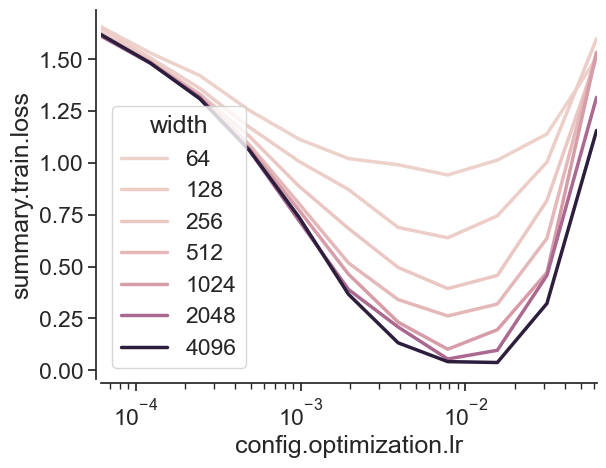

In [92]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr', y='summary.train.loss', hue='width', legend="full")
ax.set_xscale('log')
ax.set_xlim(mlp_runs_df['config.optimization.lr'].min(), mlp_runs_df['config.optimization.lr'].max())
sns.despine(ax=ax, offset=3)


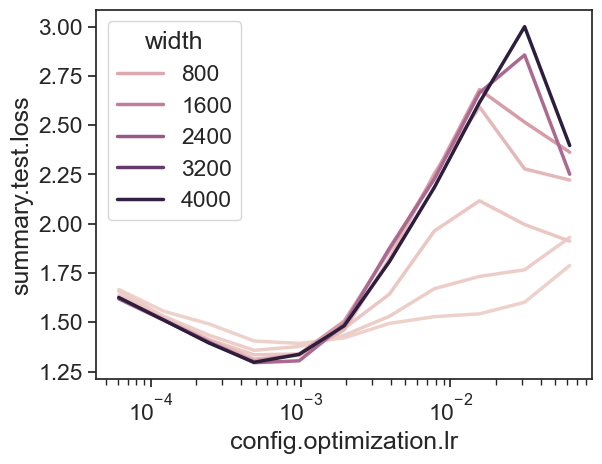

In [91]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr', y='summary.test.loss', hue='width')
ax.set_xscale('log')

## Transformer WikiText Experiment

In [51]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.use_mu_param'] == True)
]
# Add a "width" column to the dataframe.
# transformer_runs_df.loc[:, 'width'] = transformer_runs_df['config.transformer_config.d_model'].copy()

array([4096, 2048, 1024,  512,  256,  128,   64])

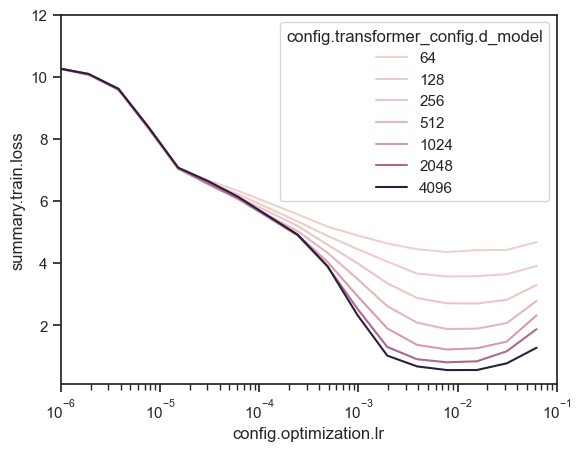

In [85]:
# Remove NaN results
runs_filtered = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr', y='summary.train.loss', hue='config.transformer_config.d_model', legend="full")
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylim(1e-1, 12)
ax.set_xlim(1e-6, 1e-1)

(1e-06, 0.1)

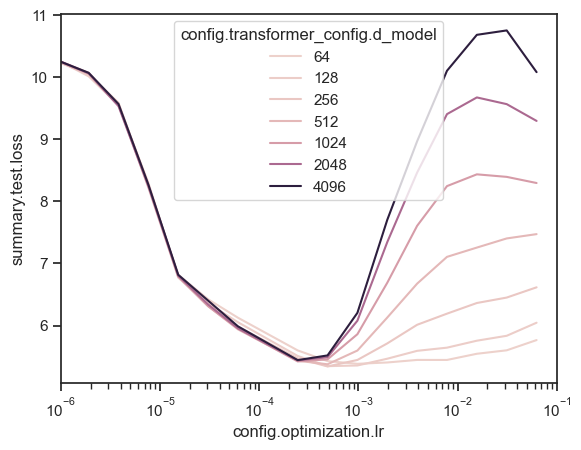

In [89]:
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr', y='summary.test.loss', hue='config.transformer_config.d_model', legend="full")
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(1e-1, 12)
ax.set_xlim(1e-6, 1e-1)